In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from tqdm import tqdm_notebook as tqdm

import sys 
sys.path.append('..')

from models import SDFNet
from backend.datasets import SDFItemDataset
from backend.datasets.utils import get_weights

import warnings
warnings.filterwarnings('ignore')

### Loading single mesh and corresponding SDF values

In [8]:
plane_mesh_up = np.load('../../data/Experiment-Cube-multi-phase-1/points_up.npy')
plane_mesh_down = np.load('../../data/Experiment-Cube-multi-phase-1/points_down.npy')
plane_mesh = np.append(plane_mesh_up, plane_mesh_down, axis=0)
plane_sdf_up = np.load('../../data/Experiment-Cube-multi-phase-1/exp_sdf_1_up.npy')
plane_sdf_down = np.load('../../data/Experiment-Cube-multi-phase-1/exp_sdf_1_down.npy')
plane_sdf = np.append(plane_sdf_up, plane_sdf_down)
plane_sdf = np.expand_dims(plane_sdf,-1)

assert plane_sdf.ndim==2 and plane_sdf.shape[1]==1
assert plane_mesh.ndim==2 and plane_mesh.shape[1]==3

In [9]:
plane_mesh

array([[ 0.12892771, -0.52610683, -0.45994685],
       [ 0.31985359, -0.05384932, -0.18708857],
       [-0.36815487,  0.16939273, -0.52041592],
       ...,
       [-0.39632601, -0.53182025,  0.3888625 ],
       [ 0.39281536, -0.00462073,  0.45248205],
       [-0.40345324, -0.25969816,  0.46478489]])

In [10]:
plane_mesh.shape

(500000, 3)

In [11]:
plane_sdf

array([[-0.01304271],
       [ 0.0192424 ],
       [-0.0100183 ],
       ...,
       [-0.0315148 ],
       [ 0.04752307],
       [ 0.03521511]])

In [12]:
np.amax(plane_sdf)

0.13944231635957918

In [13]:
np.amin(plane_sdf)

-0.1349807530320072

In [14]:
batch_size = 16384
train_steps = 400
val_steps = 200

# random points for validation
val_fraction = 0.35

val_mask = np.zeros((plane_mesh.shape[0]), dtype=np.bool)
val_ind = np.random.choice(range(plane_mesh.shape[0]), int(val_fraction*plane_mesh.shape[0]))
val_mask[val_ind] = 1

train_dataset = SDFItemDataset(plane_mesh[~val_mask], plane_sdf[~val_mask])
val_dataset = SDFItemDataset(plane_mesh[val_mask], plane_sdf[val_mask])

# balanced sampling: 1:1 positive:negative 
weights_train = get_weights(plane_sdf[~val_mask])
weights_val = get_weights(plane_sdf[val_mask])

train_sampler = WeightedRandomSampler(weights_train, batch_size*train_steps)
val_sampler = WeightedRandomSampler(weights_val, batch_size*val_steps)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)

In [15]:
model = SDFNet().cuda()

criterion = nn.MSELoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [16]:
# to clamp sdf values for both targets and model outputs
def clamp(delta, x):
    return torch.clamp(x, min=-delta, max=delta)

def mse(outputs, targets):
    return ((outputs - targets) ** 2).sum() #taking sum just to track the progress

In [17]:
class SDFTrainer:
    def __init__(self, model, criterion, optimizer, delta=0.1, checkpoints_dir='checkpoints'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.delta = delta
        os.makedirs(checkpoints_dir, exist_ok=True)
        self.checkpoints_dir=checkpoints_dir
        
    def fit(self, train_loader, val_loader, epochs, save=False):
        best_val_mse = 1e6
        for epoch in range(epochs):
            self._train(train_loader, epoch)
            val_loss, val_mse = self._validate(val_loader)
            if val_mse<best_val_mse:
                best_val_mse = val_mse
                if save:
                    self.save_weights()  
    def save_weights(self, name='model.pth'):
        torch.save(self.model.state_dict(), os.path.join(self.checkpoints_dir, name))

    def load_weights(self, weights_path):
        self.model.load_state_dict(weights_path)
        
    def _validate(self, loader):
        self.model.eval()
        running_loss = []
        running_mse = []
        
        for inputs, targets in loader:
            inputs = inputs.float().cuda()
            targets = targets.float().cuda()

            with torch.set_grad_enabled(False):
                outputs = self.model(inputs)
                loss = criterion(clamp(self.delta, outputs), clamp(self.delta, targets))
                
                running_loss.append(loss.item())
                running_mse.append(mse(outputs, targets).detach().cpu().numpy())
        
        mean_loss = np.mean(running_loss)
        mean_mse = np.mean(running_mse)
        
        print(f'val loss: {mean_loss:.5f}, val mse: {mean_mse:.5f}')
        return mean_loss, mean_mse
        
    def _train(self, loader, epoch):
        self.model.train()
        running_loss = []
        running_mse = []
        tq = tqdm(total=len(loader))
        tq.set_description('Epoch {}'.format(epoch))
        
        for inputs, targets in loader:
            inputs = inputs.float().cuda()
            targets = targets.float().cuda()

            self.optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = self.model(inputs)
                loss = self.criterion(clamp(delta, outputs), clamp(delta, targets))

            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())
            running_mse.append(mse(outputs, targets).detach().cpu().numpy())

            mean_loss = np.mean(running_loss)
            mean_mse = np.mean(running_mse)
                
            tq.update()
            tq.set_postfix(loss='{:.3f}'.format(mean_loss), mse = '{:.3f}'.format(mean_mse))            


In [18]:
epochs = 8
delta = 0.1

sdf_trainer = SDFTrainer(model, criterion, optimizer, delta)
sdf_trainer.fit(train_loader, val_loader, epochs, save=True)





val loss: 0.00039, val mse: 6.40627














val loss: 0.00026, val mse: 4.19305






















val loss: 0.00024, val mse: 3.86389






























val loss: 0.00019, val mse: 3.16329






































val loss: 0.00020, val mse: 3.34674














































val loss: 0.00020, val mse: 3.20089






















































val loss: 0.00021, val mse: 3.38565






























































val loss: 0.00021, val mse: 3.49395


## Visualization

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [20]:
def plot_sdf(xyz, sdf, n_display=100000):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    

    ind = np.random.choice(range(xyz.shape[0]), n_display)
    data = xyz[ind].T

    ax.scatter(data[0], data[2], data[1], s=5, c=sdf[ind])
    ax.view_init(20, 100)
    limit = (-0.9, 0.9)
    ax.set_xlim3d(*limit)
    ax.set_ylim3d(*limit)
    ax.set_zlim3d(*limit)

    plt.show()

### Validation GT SDF values

<IPython.core.display.Javascript object>


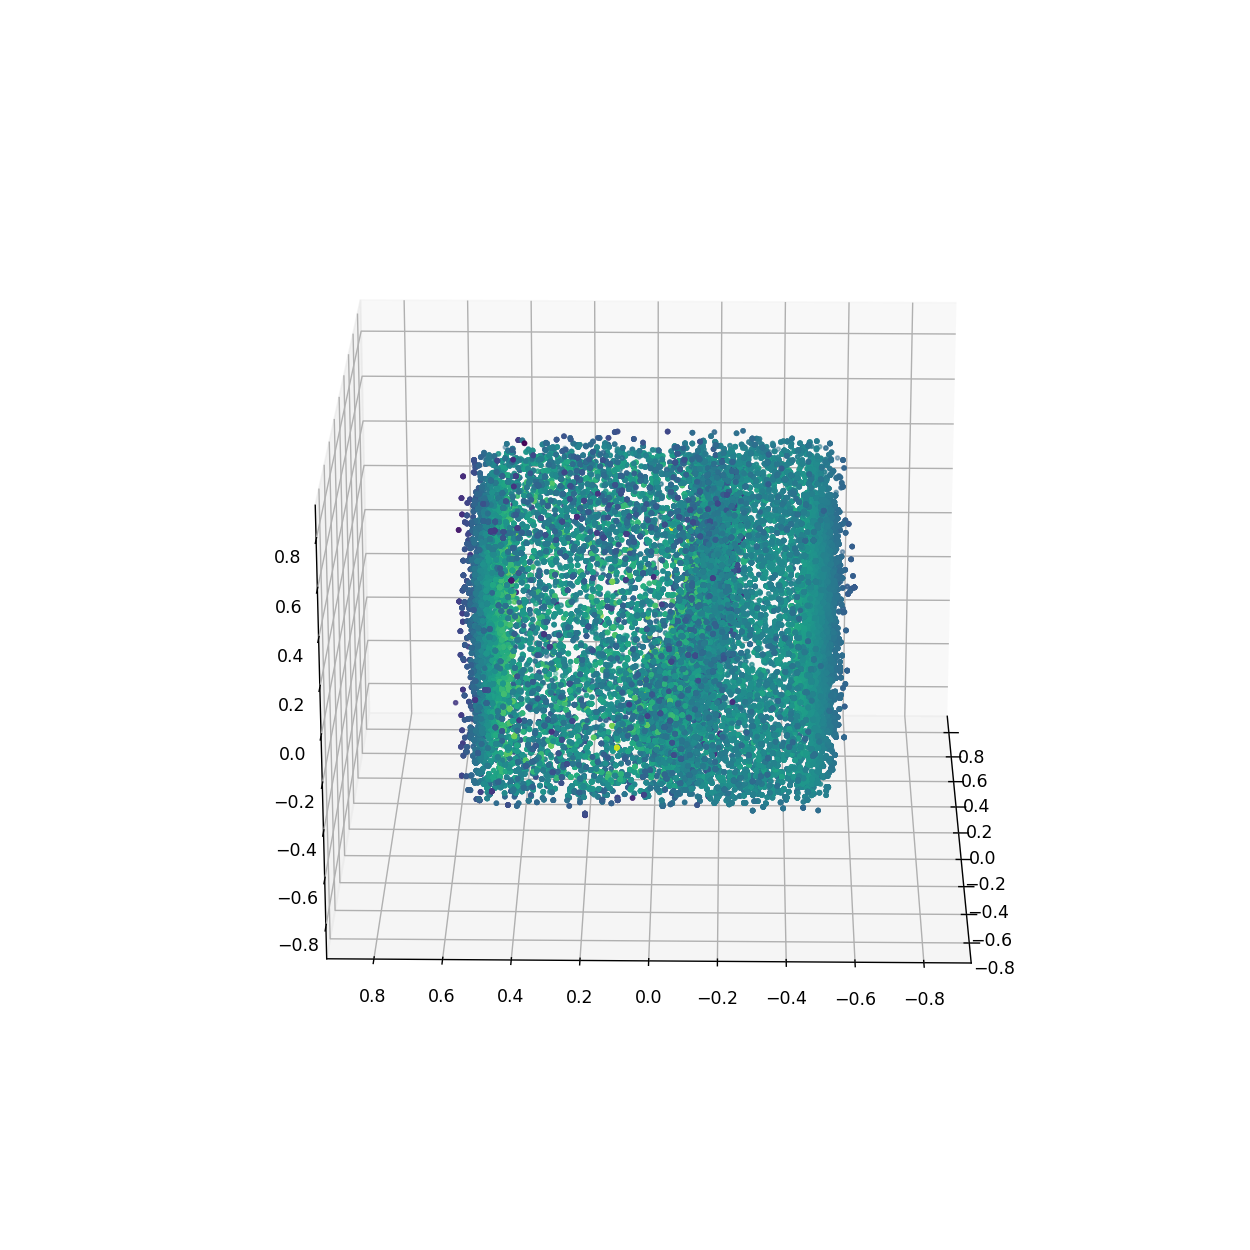

In [23]:
x, y = next(iter(val_loader))
plot_sdf(x.numpy(), y.numpy().squeeze()*2)

## Marching Cube

In [46]:
# Marching Cube Test
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid

N = 256

# NOTE: the voxel_origin is actually the (bottom, left, down) corner, not the middle
voxel_origin = [-1, -1, -1]
voxel_size = 2.0 / (N - 1)


overall_index = torch.arange(0, N ** 3, 1, out=torch.LongTensor())
samples = torch.zeros(N ** 3, 4)


# transform first 3 columns
# to be the x, y, z index
samples[:, 2] = overall_index % N
samples[:, 1] = (overall_index.long() / N) % N
samples[:, 0] = ((overall_index.long() / N) / N) % N

# transform first 3 columns
# to be the x, y, z coordinate
samples[:, 0] = (samples[:, 0] * voxel_size) + voxel_origin[2]
samples[:, 1] = (samples[:, 1] * voxel_size) + voxel_origin[1]
samples[:, 2] = (samples[:, 2] * voxel_size) + voxel_origin[0]

num_samples = N ** 3
samples.requires_grad = False

samples

tensor([[-1.0000, -1.0000, -1.0000,  0.0000],
        [-1.0000, -1.0000, -0.9922,  0.0000],
        [-1.0000, -0.9999, -0.9843,  0.0000],
        ...,
        [ 1.0078,  1.0078,  0.9843,  0.0000],
        [ 1.0078,  1.0078,  0.9922,  0.0000],
        [ 1.0078,  1.0078,  1.0000,  0.0000]])

In [59]:
x_grid = samples[:,0:3]

head = 0
max_batch = 32 ** 3

while head < num_samples:
    sample_subset = samples[head : min(head + max_batch, num_samples), 0:3].cuda()

    samples[head : min(head + max_batch, num_samples), 3] = (
        model(sample_subset.cuda())
        .squeeze(1)
        .detach()
        .cpu() * 2 - 0.07
    )
#     samples[head : min(head + max_batch, num_samples), 3] = (
#         np.sign(model(sample_subset.cuda())
#         .squeeze(1)
#         .detach()
#         .cpu() * 2 - 0.07) * (-1) * (model(sample_subset.cuda())
#         .squeeze(1)
#         .detach()
#         .cpu() * 2)
#     )
    head += max_batch

sdf_values_grid = samples[:, 3]
sdf_values_grid = sdf_values_grid.reshape(N, N, N)
sdf_values_grid

tensor([[[-0.3971, -0.3961, -0.3952,  ..., -0.9510, -0.9558, -0.9606],
         [-0.3948, -0.3938, -0.3929,  ..., -0.9479, -0.9526, -0.9574],
         [-0.3925, -0.3915, -0.3906,  ..., -0.9448, -0.9496, -0.9545],
         ...,
         [-0.3920, -0.3909, -0.3898,  ..., -0.8952, -0.9000, -0.9047],
         [-0.3943, -0.3932, -0.3921,  ..., -0.8980, -0.9027, -0.9074],
         [-0.3965, -0.3954, -0.3943,  ..., -0.9008, -0.9054, -0.9101]],

        [[-0.3951, -0.3941, -0.3932,  ..., -0.9470, -0.9518, -0.9566],
         [-0.3928, -0.3918, -0.3909,  ..., -0.9438, -0.9487, -0.9535],
         [-0.3905, -0.3896, -0.3886,  ..., -0.9407, -0.9455, -0.9504],
         ...,
         [-0.3901, -0.3890, -0.3879,  ..., -0.8912, -0.8960, -0.9007],
         [-0.3924, -0.3913, -0.3902,  ..., -0.8940, -0.8987, -0.9034],
         [-0.3947, -0.3935, -0.3923,  ..., -0.8968, -0.9015, -0.9062]],

        [[-0.3931, -0.3922, -0.3912,  ..., -0.9430, -0.9479, -0.9527],
         [-0.3909, -0.3899, -0.3889,  ..., -0

<IPython.core.display.Javascript object>


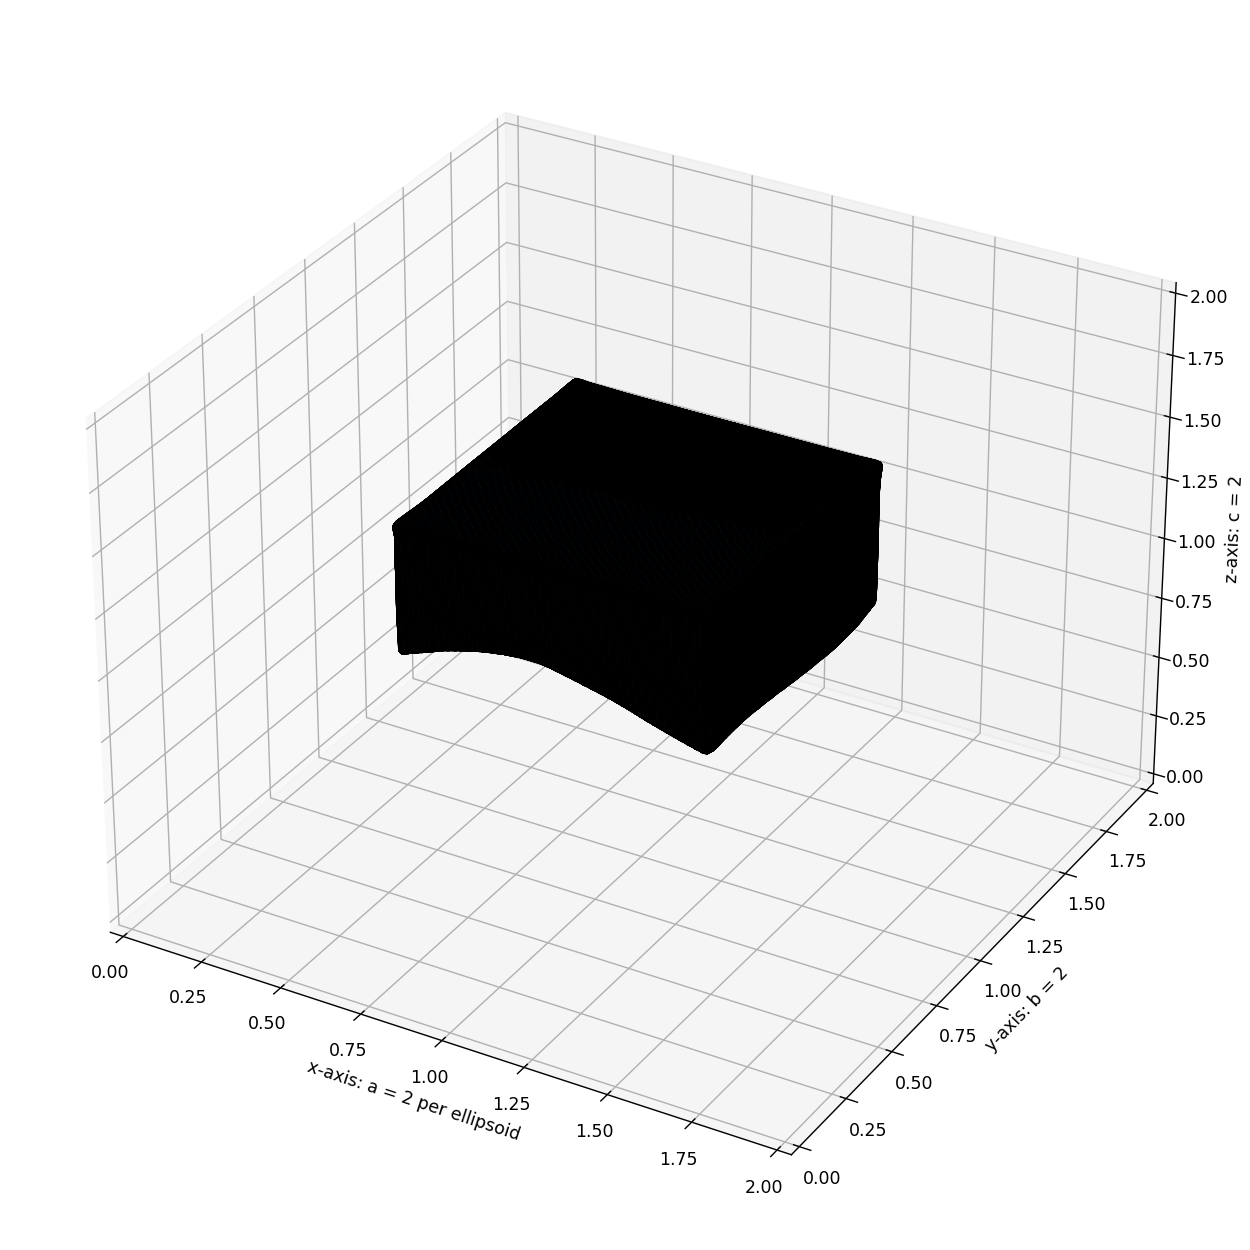

In [60]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes_lewiner(sdf_values_grid.numpy(), level=0.0, spacing=[voxel_size] * 3)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 2 per ellipsoid")
ax.set_ylabel("y-axis: b = 2")
ax.set_zlabel("z-axis: c = 2")

ax.set_xlim(0, 2)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 2)  # b = 10
ax.set_zlim(0, 2)  # c = 16

plt.tight_layout()
plt.show()

In [61]:
import plyfile
import logging
ply_filename_out = '../../data/Experiment-Cube-multi-phase-1/cube-down.ply'
voxel_grid_origin = [-1, -1, -1]
scale = None
offset = None
# transform from voxel coordinates to camera coordinates
# note x and y are flipped in the output of marching_cubes
mesh_points = np.zeros_like(verts)
mesh_points[:, 0] = voxel_grid_origin[0] + verts[:, 0]
mesh_points[:, 1] = voxel_grid_origin[1] + verts[:, 1]
mesh_points[:, 2] = voxel_grid_origin[2] + verts[:, 2]

# apply additional offset and scale
if scale is not None:
    mesh_points = mesh_points / scale
if offset is not None:
    mesh_points = mesh_points - offset

# try writing to the ply file

num_verts = verts.shape[0]
num_faces = faces.shape[0]

verts_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])

for i in range(0, num_verts):
    verts_tuple[i] = tuple(mesh_points[i, :])

faces_building = []
for i in range(0, num_faces):
    faces_building.append(((faces[i, :].tolist(),)))
faces_tuple = np.array(faces_building, dtype=[("vertex_indices", "i4", (3,))])

el_verts = plyfile.PlyElement.describe(verts_tuple, "vertex")
el_faces = plyfile.PlyElement.describe(faces_tuple, "face")

ply_data = plyfile.PlyData([el_verts, el_faces])
logging.debug("saving mesh to %s" % (ply_filename_out))
ply_data.write(ply_filename_out)

In [24]:
sdf_values = model(x.float().cuda()) # model predictions
sdf_values = sdf_values.detach().cpu().numpy() * 2

### Predicted SDF values

<IPython.core.display.Javascript object>


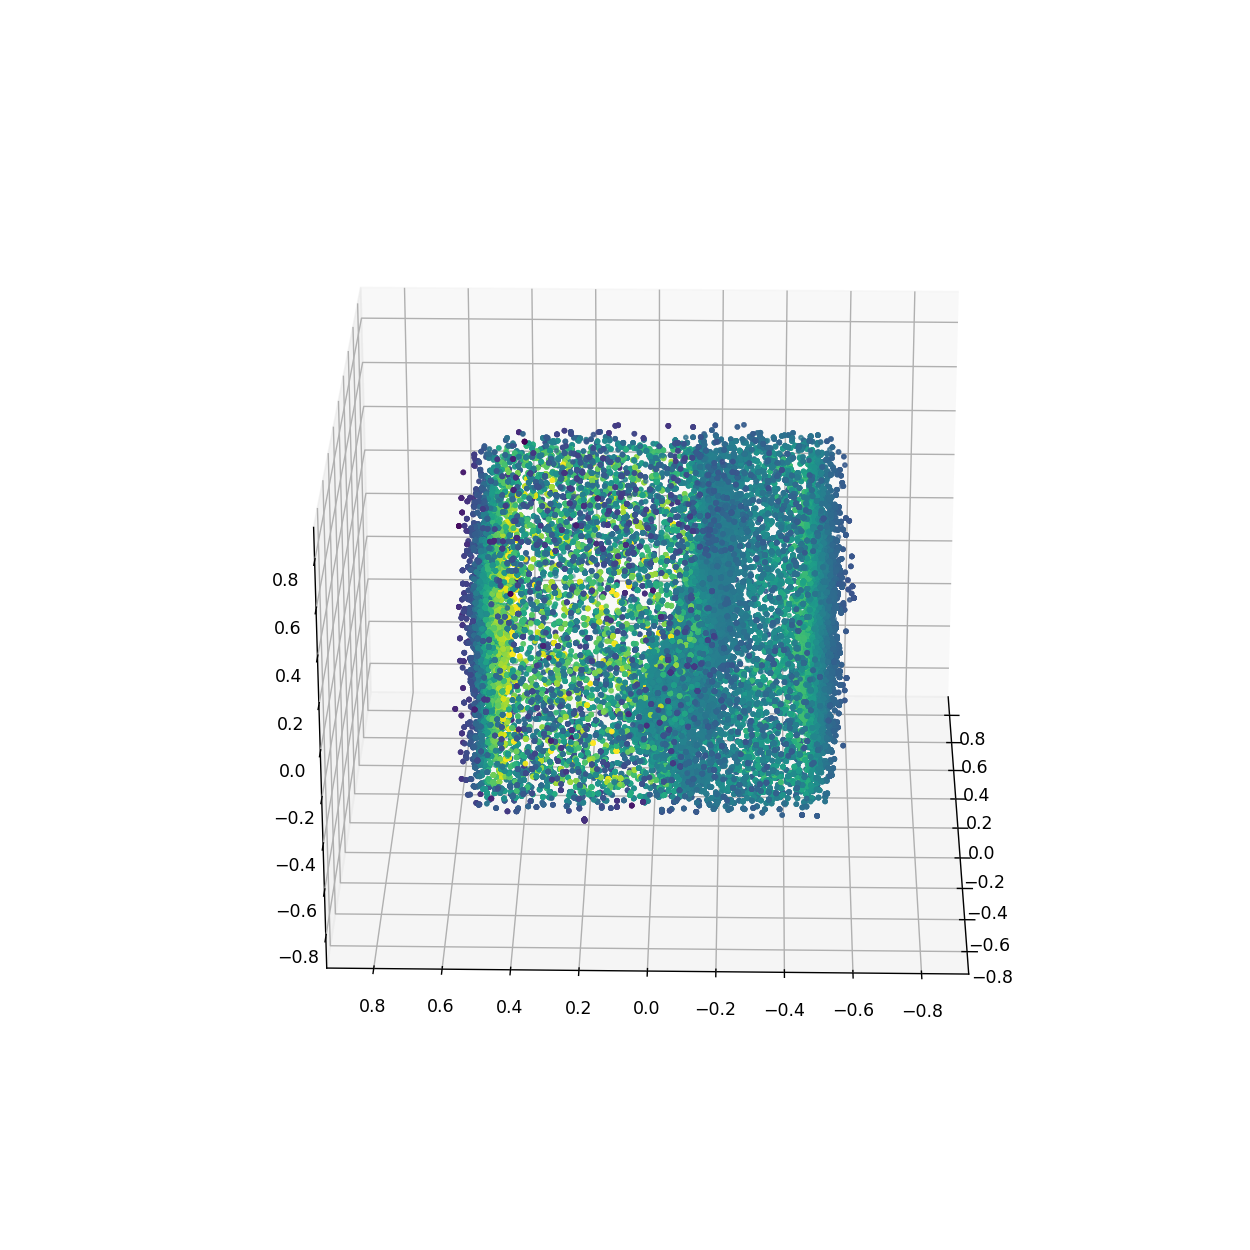

In [25]:
plot_sdf(x.numpy(), sdf_values.squeeze())

### GT shell (surface points)

<IPython.core.display.Javascript object>


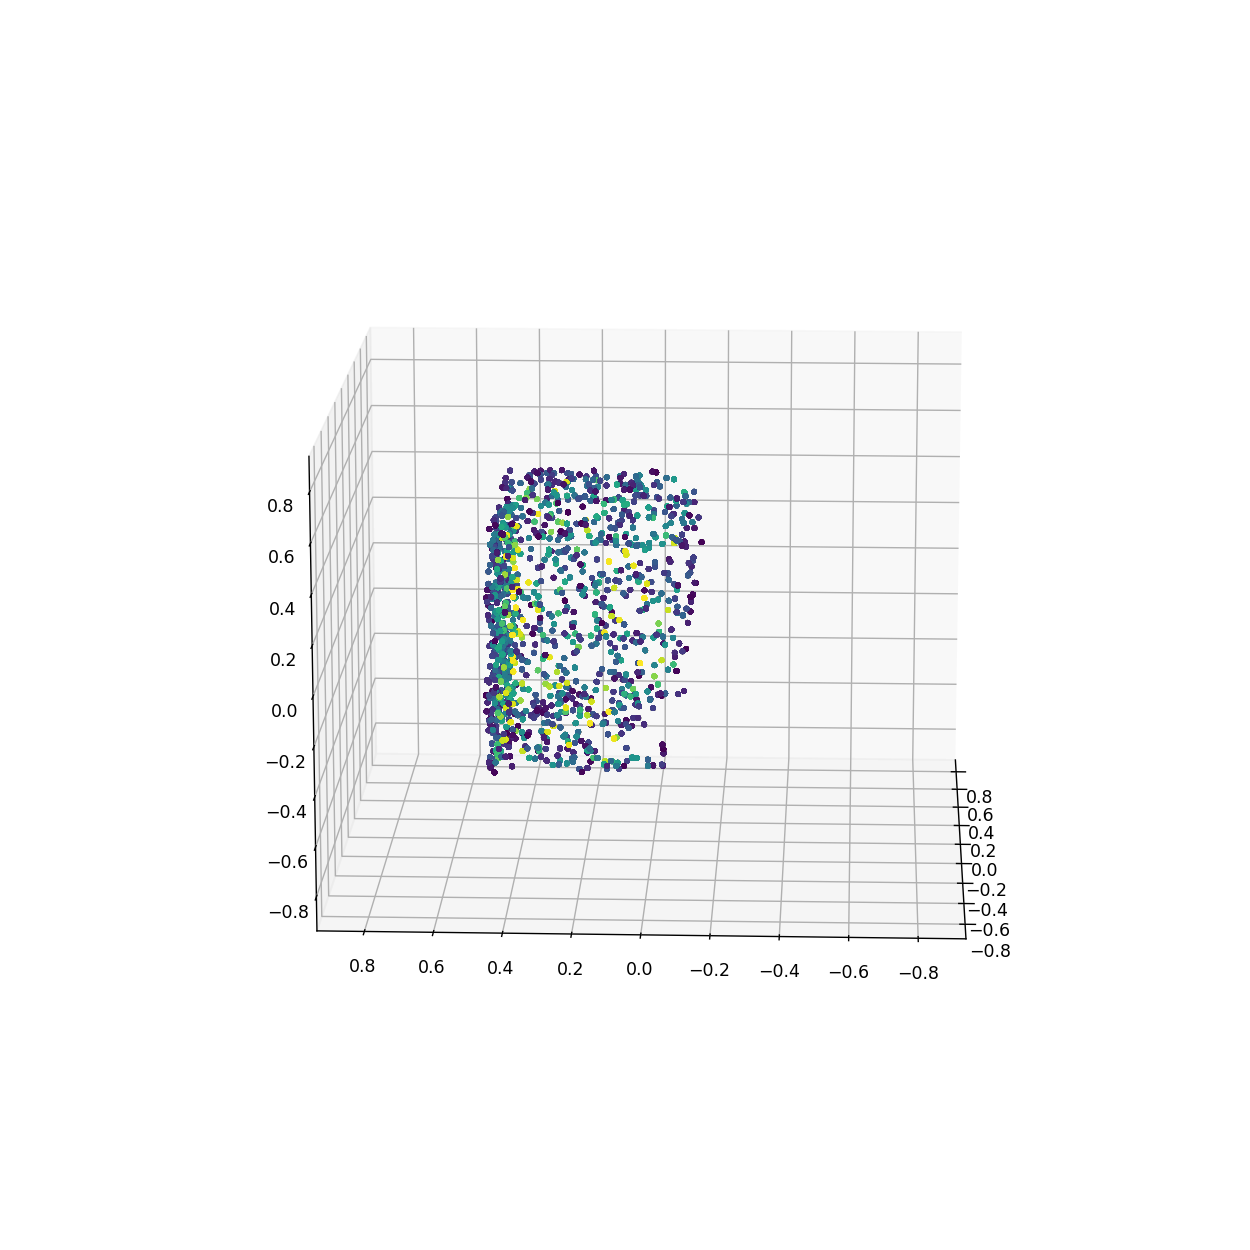

In [43]:
ind = sdf_values.squeeze()>0.07
plot_sdf(x[ind, :].numpy(), sdf_values[ind,:].squeeze())

### Predicted shell

<IPython.core.display.Javascript object>


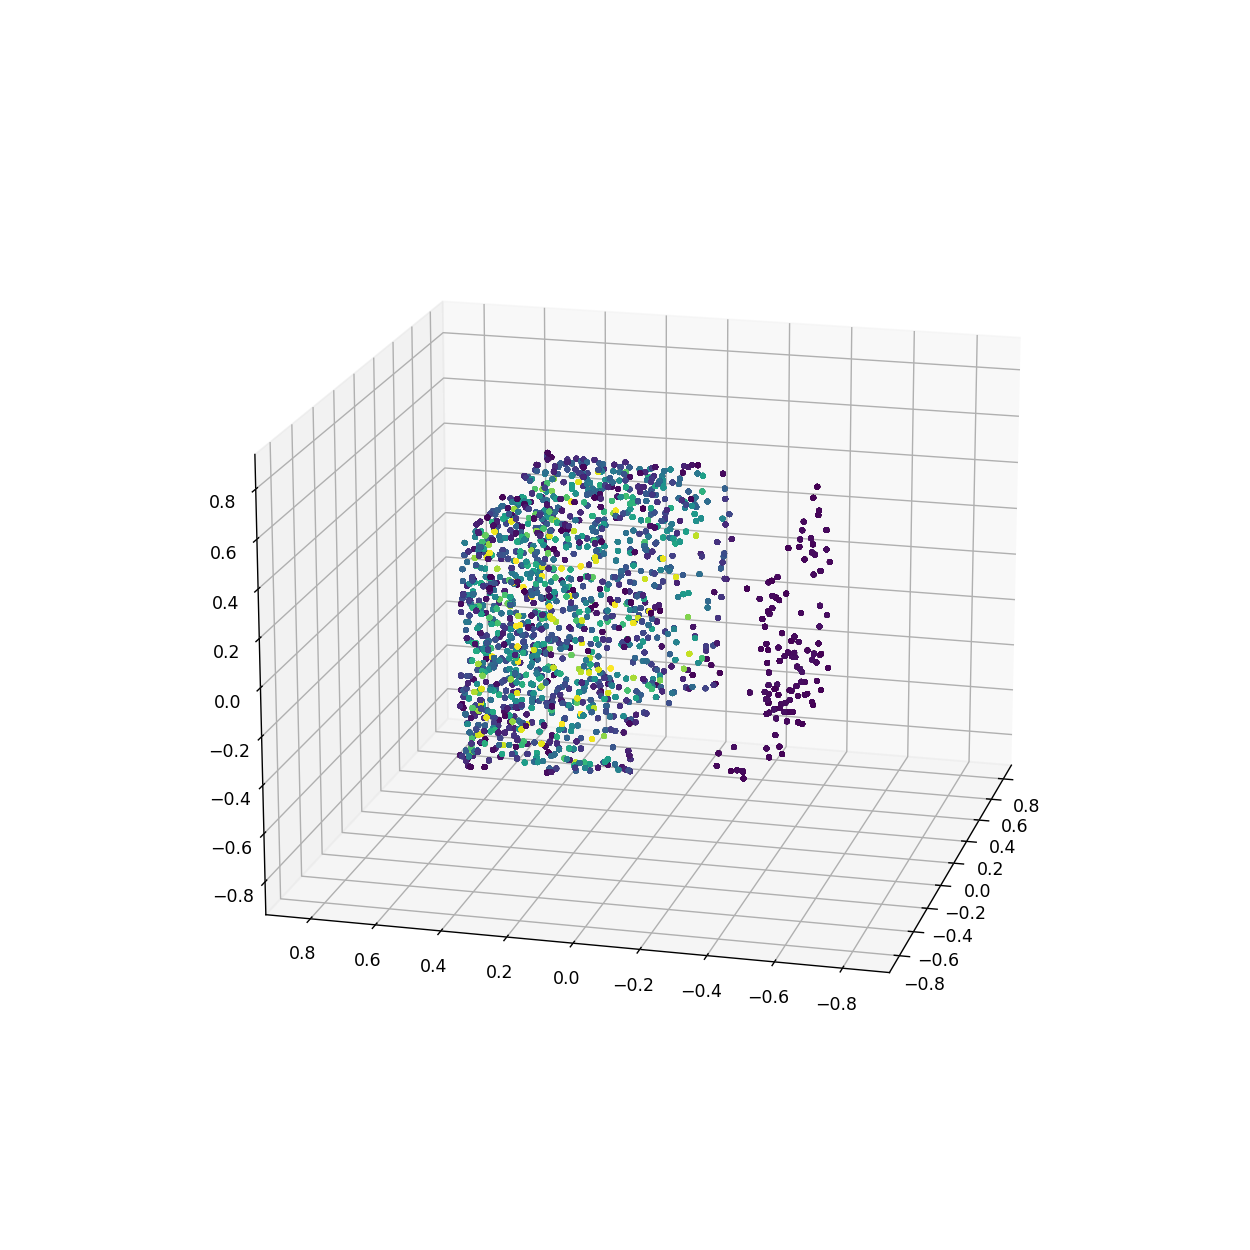

In [44]:
ind = sdf_values.squeeze()>0.065
plot_sdf(x[ind, :].numpy(), sdf_values[ind,:].squeeze())

<IPython.core.display.Javascript object>


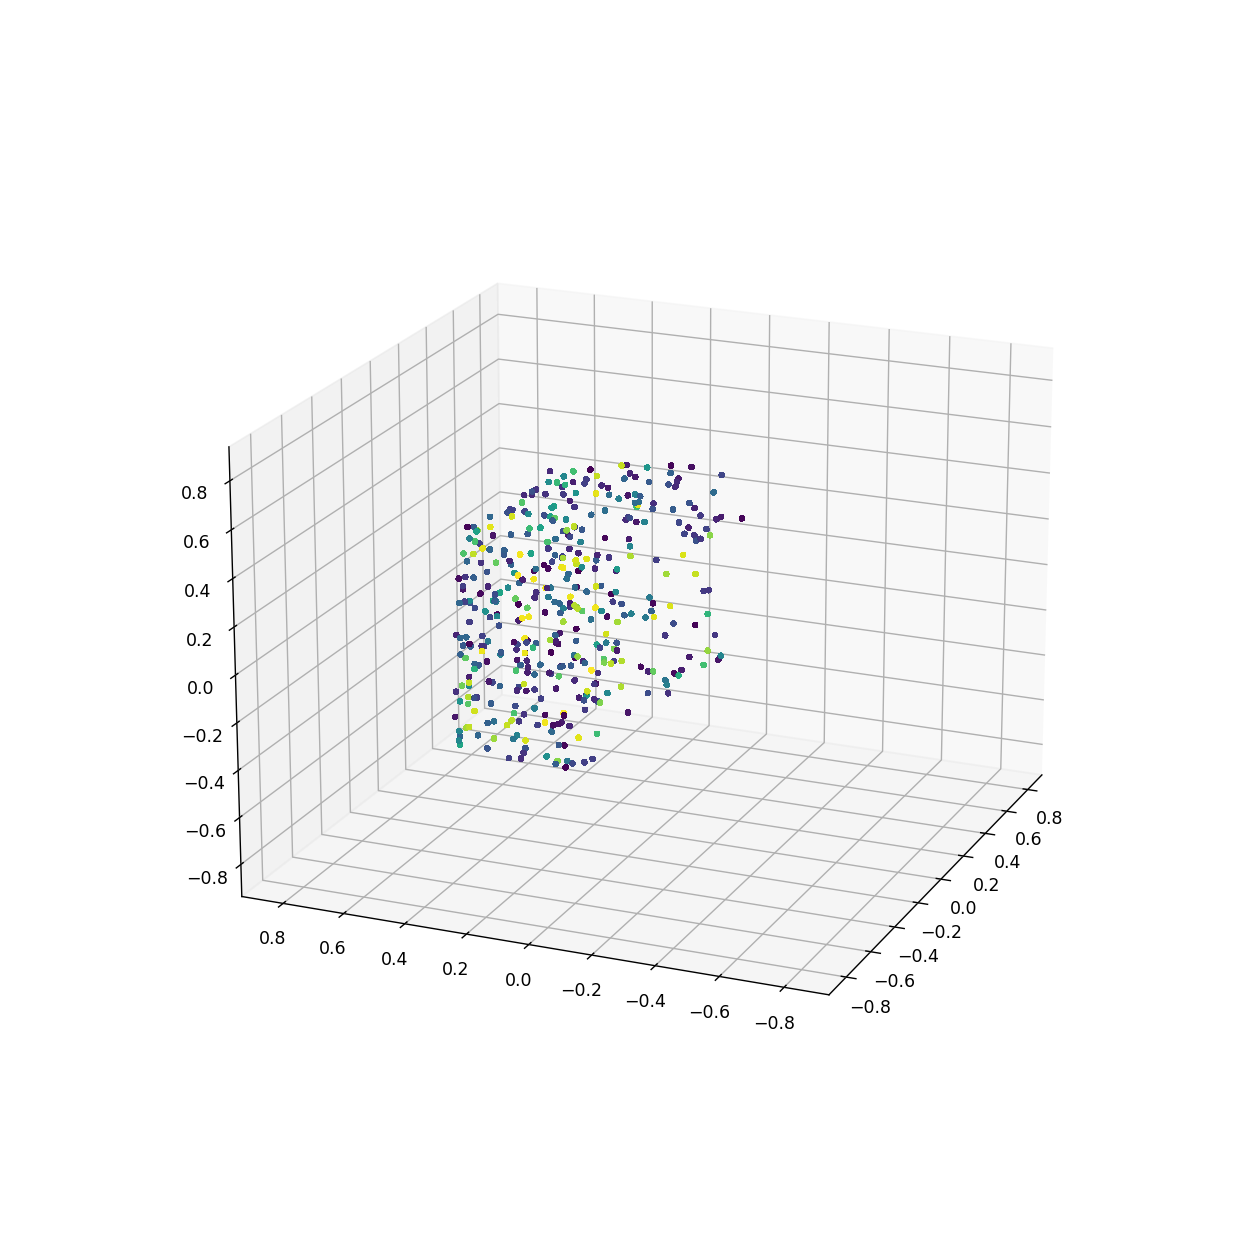

In [45]:
ind = sdf_values.squeeze()>=0.1
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())